 # A Quick COVID-19 Data Analysis

 This notebook is a brief exploration and analysis of the data on the COVID-19
 virus published at <http://covidtracking.com>. I am a data scientist, not an
 epidemiologist or a doctor, so my comments exclusively pertain to statistical
 trends and not epidemic or medical ones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime as dt


In [2]:
url = "https://covidtracking.com/api/us/daily"
df = pd.read_json(url)


 ## Data Processing

 Basic data processing here:
 - drop redundant/unnecessary columns
 - parse dates
 - generate date labels
 - sort on date
 - fill NA fields with 0



In [3]:
data = df.drop(['hash','dateChecked'], axis=1)
data.date = data.date.astype(str).apply(dt.datetime.strptime, args=["%Y%m%d"])
data['day'] = data.date.apply(lambda d: d.strftime("%b %d"))
data.sort_values('date', inplace=True)
data.set_index('date',inplace=True)
data.fillna(0, inplace=True)

data.head()


,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,day
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,Jan 22
2020-01-23,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,Jan 23
2020-01-24,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,Jan 24
2020-01-25,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,Jan 25
2020-01-26,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,Jan 26


 It's pretty trivial to look at the rate of positive tests--we've all seen this
 chart many times before.

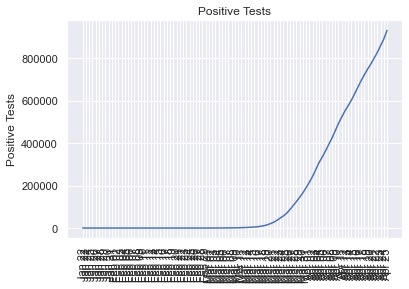

In [4]:
plt.plot(data.day, data.positive)
plt.xticks(rotation=90)
plt.title("Positive Tests")
plt.ylabel("Positive Tests")

plt.show()


 If positive cases are experiencing exponential growth, then their log will be
 linear. We can plot the above chart on a log scale to see if that's the case.

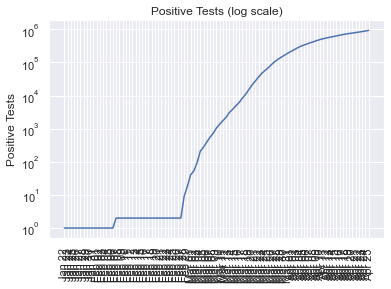

In [5]:
plt.plot(data.day, data.positive)
plt.yscale("log")
plt.xticks(rotation=90)
plt.title("Positive Tests (log scale)")
plt.ylabel("Positive Tests")

plt.show()


 We can also back-extrapolate an infection rate from the death rate. We know
 the average time from infection to death is 14 days. Therefore, all the people
 who died on a given day were likely infected 14 days earlier. Because we have
 a rough grasp of the death rate among the infected population, we can
 extrapolate this to calculate how many people were likely infected on that
 day. Because deaths are likely more accurately tracked than infections (due to
 the lack of testing) this may give us a better sense of the magnitude of the
 disease.

 First we look at the death rate, unmodified.

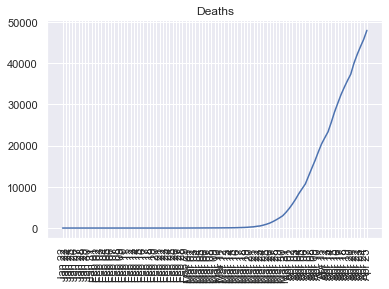

In [6]:
plt.plot(data.day, data.death)
plt.xticks(rotation=90)
plt.title("Deaths")

plt.show()


 A recent [study][1] of COVID-19 in China found a death rate of about 0.66% when
 they counted mild and asymptomatic cases that were not counted by previous
 studies, so we'll use that to extrapolate the infected population from the
 death rate. They also calculated a death rate among *symptomatic* cases at
 1.38%.

 [1]: https://www.cnn.com/2020/03/30/health/coronavirus-lower-death-rate/index.html

In [7]:
# Back-extrapolation
delta = dt.timedelta(days = -14)
death_rate = .0066
death_rate_s = .0138

def estimate(row):
    return {
        'date': (d := row.name.date() + delta),
        'infected': row.death / death_rate,
        'symptomatic': row.death / death_rate_s,
        'day': d.strftime("%b %d")
    }

estimates = data.apply(estimate, axis=1, result_type='expand')
estimates.set_index('date', inplace=True)
estimates.tail()


,infected,symptomatic,day
date,,,
2020-04-07,6.059848e+06,2.898188e+06,Apr 07
2020-04-08,6.383030e+06,3.052754e+06,Apr 08
2020-04-09,6.668788e+06,3.189420e+06,Apr 09
2020-04-10,6.937273e+06,3.317826e+06,Apr 10
2020-04-11,7.269697e+06,3.476812e+06,Apr 11


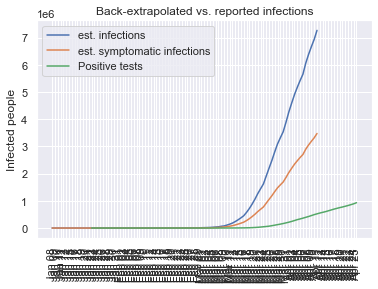

In [8]:
# Plot estimated and reported data
plt.plot(estimates.set_index('day').infected, label="est. infections")

plt.plot(estimates.set_index('day').symptomatic, label="est. symptomatic infections")

plt.plot(data.set_index('day').positive, label="Positive tests")

plt.legend()
plt.xticks(rotation=90)
plt.ylabel("Infected people")
plt.title("Back-extrapolated vs. reported infections")

plt.show()


 The growth of our estimated curve is pretty terrifying--it dwarfs the growth
 documented cases by orders of magnitude. According to the study, many of these
 cases could be asymptomatic, but would still be shedding the virus,
 potentially transmitting it to vulnerable people.

 By plotting these on a log scale, we can more easily extrapolate and compare
 the rates of growth in the death rate and the reported infections.

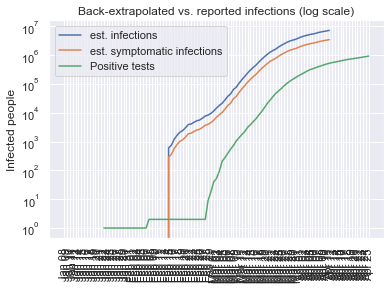

In [9]:
# Plot estimated and reported data
plt.plot(estimates.set_index('day').infected, label="est. infections")

plt.plot(estimates.set_index('day').symptomatic, label="est. symptomatic infections")

plt.plot(data.set_index('day').positive, label="Positive tests")

plt.legend()
plt.yscale("log")
plt.xticks(rotation=90)
plt.ylabel("Infected people")
plt.title("Back-extrapolated vs. reported infections (log scale)")

plt.show()


 The logs of both counts are tracking at about the same rate, but because there
 are so many unaccounted cases before even the first positive test, this
 actually means that number of unaccounted for cases is rising exponentially as
 well. We can plot this too:

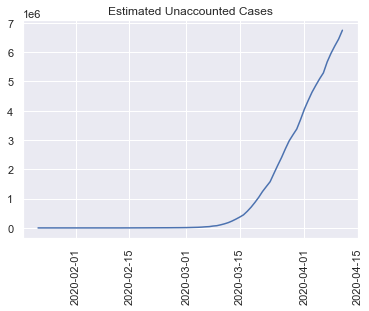

In [10]:
diff = estimates.infected - data.positive

plt.plot(diff)
plt.xticks(rotation=90)
plt.title("Estimated Unaccounted Cases")

plt.show()


 There were likely more than 500,000 untested people carrying the coronavirus
 on March 17th--how many could there be now, two weeks later?